In [1]:
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np

In [53]:
env = gym.envs.make("CartPole-v1")

In [2]:
env = gym.envs.make("Taxi-v3")

In [3]:
def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 2

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v0 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()

AttributeError: 'OutStream' object has no attribute 'getvalue'

<Figure size 432x288 with 0 Axes>

In [3]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [4]:
class DQL():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05, dropout=0.4):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
#                             torch.nn.Embedding(500, hidden_dim)
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(dropout),                        
#                             torch.nn.LeakyReLU(),
#                             torch.nn.Linear(hidden_dim, hidden_dim*2),
#                             torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
            self.num_param_updates=0

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        self.model.train()
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.Tensor(state))
        
    

In [5]:
class OneHotGenerator():
    def __init__(self, num_labels):
        self.num_labels = num_labels
        self.one_hot_array = np.eye(num_labels)
    
    def get_one_hot(self, label):
        return self.one_hot_array[label]
    

In [6]:
def learn(model_target, model_train, memory, size, n_update, gamma=0.9):
        """ Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        if len(memory) >= size:
            states = []
            targets = []
            # Sample a batch of experiences from the agent's memory
            batch = random.sample(memory, size)
            
            # Extract information from the data
            for state, action, next_state, reward, done in batch:
                states.append(state)
                # Predict q_values
                q_values = model_train.model(torch.Tensor(state)).tolist()
                if done:
                    q_values[action] = reward
                else:
                    q_values_next = model_target.model(torch.Tensor(next_state)).detach()
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            model_train.update(states, targets)
            model_train.num_param_updates += 1
            if model_train.num_param_updates % n_update ==0:
                model_target.model.load_state_dict(model_train.model.state_dict())

In [7]:
def q_learning(env, model_train, model_target, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=1000, soft=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    one_hot_gen =  OneHotGenerator(env.observation_space.n)
    for episode in range(episodes):
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        state = one_hot_gen.get_one_hot(state)
#         state = list(env.env.decode(state))
        done = False
        total = 0
        steps = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            steps +=1            

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model_target.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            next_state = one_hot_gen.get_one_hot(next_state)
#             next_state = list(env.env.decode(next_state))
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
#             q_values = model.predict(state).tolist()
            if steps>100:
                learn(model_target, model_train, memory, replay_size, n_update, gamma)
            
            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
    return final

In [8]:
# Number of states
n_state = env.observation_space.n
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 150
# Learning rate
lr = 0.01

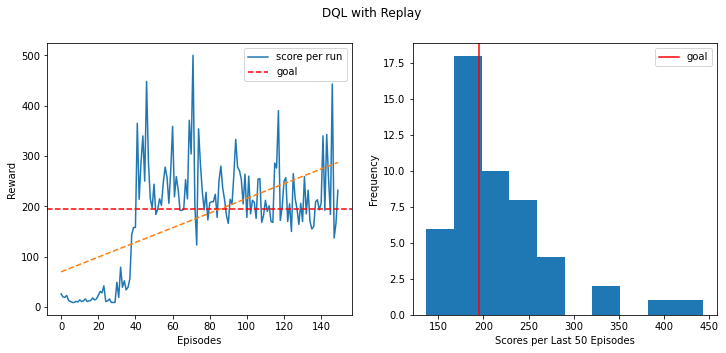

In [10]:
dqn_replay = DQL(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=0.99, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

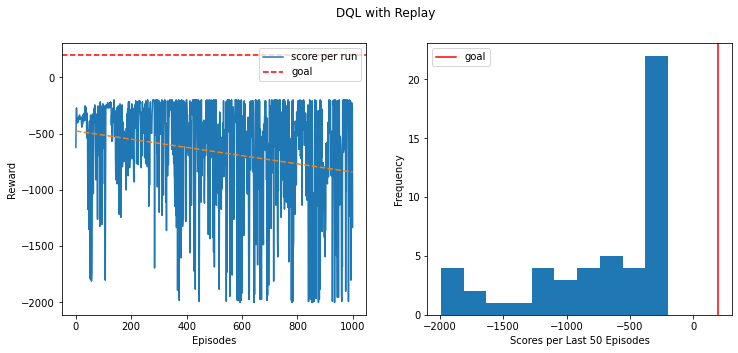

In [9]:
dqn_replay = DQL(4, 6, 150, lr)
replay = q_learning(env, dqn_replay, 
                    1000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

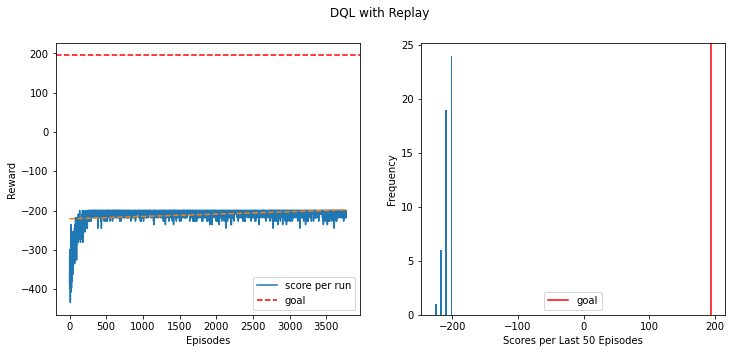

In [ ]:
dqn_train = DQL(4, 6, n_hidden, lr)
dqn_target= DQL(4, 6, n_hidden, lr)

dqn_train.model.train()
dqn_target.model.eval()

replay = q_learning(env, dqn_train, dqn_target, 
                    5000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

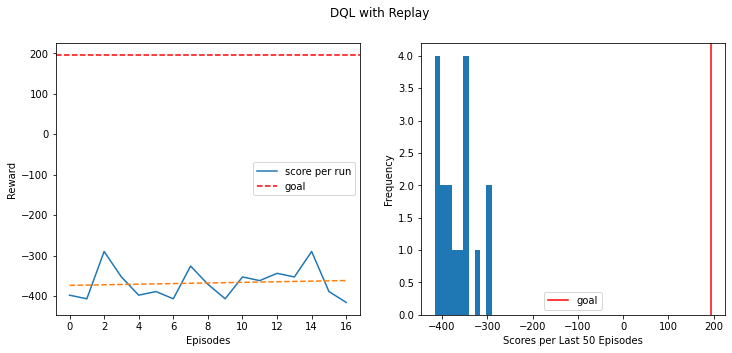

In [ ]:
dqn_train = DQL(n_state, 6, n_hidden, lr)
dqn_target= DQL(n_state, 6, n_hidden, lr)

dqn_train.model.train()
dqn_target.model.eval()

replay = q_learning(env, dqn_train, dqn_target, 
                    5000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

In [10]:
list  =[(np.array([0,0,1]),2,3, True), (np.array([0,0,1]),3,4), (np.array([0,0,1]),4,5)]
torch.from_numpy(np.stack(np.array(list)[:, 2]))

tensor([3, 4, 5], dtype=torch.int32)